In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.facecolor'] = 'white'
import matplotlib as mpl
mpl.rcParams['grid.color'] = 'lightgrey'
#needed for all graphs
colors = ['black', 'yellowgreen', 'thistle', 'slategrey', 'm']
alphas = [1, .5, 1, 1]
s = 5

from scipy.sparse import csr_matrix

from src.ItemItemRecommender import ItemItemRecommender
from sklearn.model_selection import train_test_split


from src.item_item_prototype import get_ratings_data, load_movies

import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:>

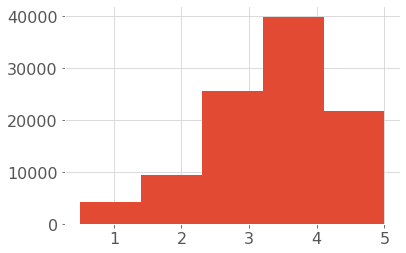

In [33]:
ratings_content = pd.read_csv('data/ml-latest-small/ratings.csv')
ratings_content.head()
# ratings_content.shape # 100,836 reviews 4
ratings_content.rating.hist(bins = 5)
# mean_scale = (ratings_content.rating - ratings_content.rating.mean())
# mean_scale.hist(bins = 5)
# ratings_content.rating.var()


In [34]:
utility_matrix = ratings_content.pivot_table(values='rating', index = 'userId', columns = 'movieId')
utility_matrix.to_csv('utility.csv')
utility_matrix.shape # 610 unique users, 9724 unique movies

(610, 9724)

In [35]:
user_ratings = (utility_matrix>0).sum(axis=1)
movie_ratings = (utility_matrix>0).sum(axis=0)
umin, umax = user_ratings.min(), user_ratings.max() #(20, 2698)
imin, imax = movie_ratings.min(), movie_ratings.max() #(1, 329)



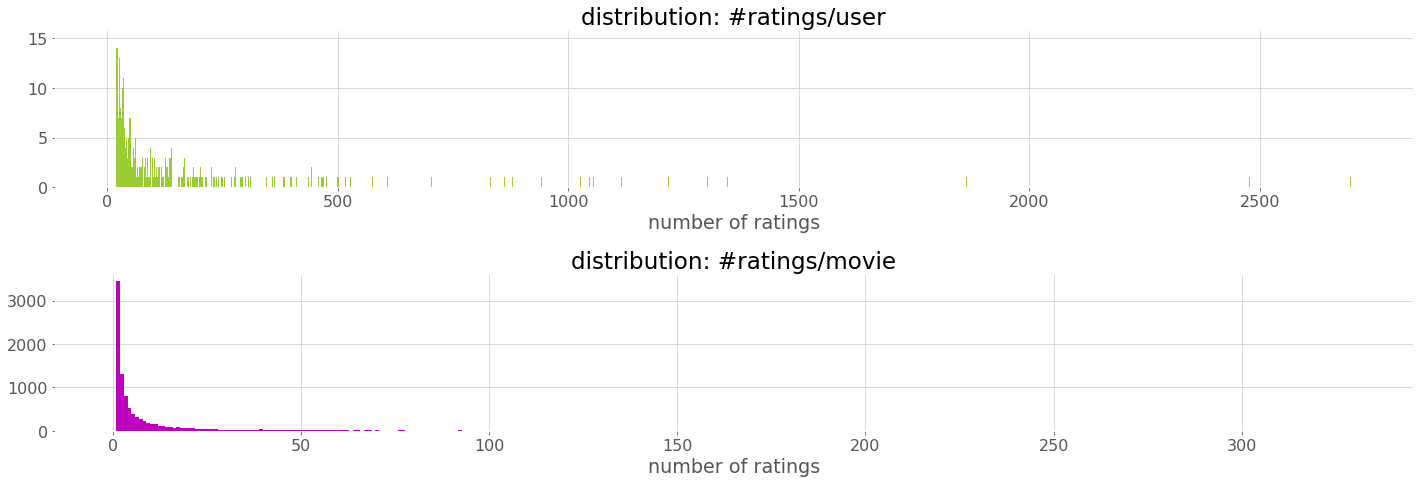

In [36]:
ylim = 0,60
xlim = 0,700
fig, axs = plt.subplots(2, 1, figsize = (20,7))
axs[0].hist(user_ratings, color = colors[1], bins = umax)
axs[0].set_title('distribution: #ratings/user')
axs[0].set_xlabel('number of ratings')
# axs[0].set_ylabel('number of times we see x number of ratings')
# axs[0].set_xlim(xlim)
# axs[0].set_ylim(ylim)
axs[1].hist(movie_ratings, color = colors[4], bins = imax)
axs[1].set_title('distribution: #ratings/movie')
axs[1].set_xlabel('number of ratings')
# axs[1].set_ylabel('number of times we see x number of ratings')
# axs[1].set_xlim(xlim)
# axs[1].set_ylim(ylim)
fig.tight_layout()
fig.savefig('ratings distribution.png')

In [37]:
utility_matrix = ratings_content.pivot_table(values='rating', index = 'userId', columns = 'movieId')
utility_matrix.shape
utility_matrix.head()
utility_matrix_zeros = utility_matrix.fillna(0)
utility_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
utility_matrix.to_csv('utility_zero.csv')

In [41]:
def sparse(df, values, rows, cols):
    piv = df.pivot_table(values = values, index = rows, columns = cols)
    tot = df.shape[0]
    user_tot = len((piv>0).sum(axis=1))
    item_tot = len((piv>0).sum(axis=0))
    return f'The density is: {tot/(user_tot*item_tot)}'
print(sparse(ratings_content, 'rating', 'userId', 'movieId'))

The density is: 0.016999683055613623


In [43]:
def sparse_loss(df, values, rows, cols, frac = 1-1/np.e, random_state=1111):
    df0 = df.sample(frac = frac, replace = False, random_state = random_state)
    piv = df0.pivot_table(values = values, index = rows, columns = cols)
    tot = df0.shape[0]
    user_tot = len((piv>0).sum(axis=1))
    item_tot = len((piv>0).sum(axis=0))
    lost_u = len(df[rows].unique()) - len(df0[rows].unique())
    lost_m = len(df[cols].unique()) - len(df0[cols].unique())
    if lost_u > 0 or lost_m >0:
        flag = 'DO'
    else:
        flag = 'DO NOT'
    return f'The split density is: {tot/(user_tot*item_tot)}\nIn our split we lost {lost_u} users and {lost_m} items\nWe {flag} have a density problem'

print(sparse_loss(ratings_content, 'rating', 'userId', 'movieId'))

The split density is: 0.01271828658994046
In our split we lost 0 users and 1508 items
We DO have a density problem


In [46]:
# highest rated movie
average_rating = ratings_content.groupby('movieId').mean()['rating']
movies = pd.read_csv('data/ml-latest-small/movies.csv', index_col = False)
movies.set_index('movieId', inplace = True)

In [47]:
movies.loc[average_rating.idxmax()]

title     Lamerica (1994)
genres    Adventure|Drama
Name: 53, dtype: object

In [48]:
movies

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


In [ ]:
ratings_as_mat = csr_matrix((ratings_content.rating, 
        ((ratings_content.userId), (ratings_content.movieId))))


rec = ItemItemRecommender(neighborhood_size=75)
rec.fit(ratings_as_mat)

In [ ]:
!pwd